# Lab Assignment Four: Evaluation and Multi-Layer Perceptron

***Sahil Johari, Prabhat Pal, Pritheesh Panchmahalkar, Azeem Merchant***
<hr>

# 1.Business Understanding

In this lab, we will implement our custom multi-layer perceptron and tune the hyperparameters to achieve best performance. We have selected the [CIFAR-10](https://www.kaggle.com/c/cifar-10/data) image dataset for this lab assignment. This dataset consists of 50,000 images of dimension 32x32 pixels which are spread across 10 different classes of 5,000 images each. 

Here are the classes from the dataset and 10 random images from each of them:
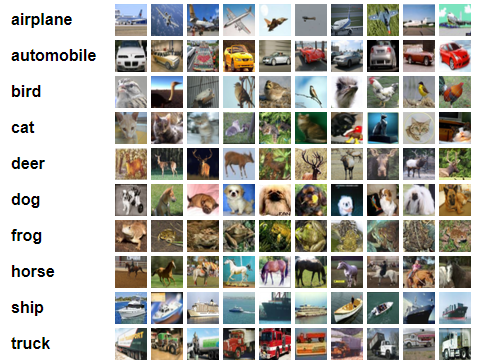

We have used a small portion of this dataset consisting of 5,000 images to demonstrate as the computational constraints did not allow us to run the entire dataset of 50,000 images.
 
**Task for our prediction algorithm**
The primary task is to predict what class an image belongs to by recognizing the object that is in the image. Before the prediction task, our algorithm is trained using images from training dataset and then tested on the remaining testing dataset. 

**Business Case for Algorithm**
* Our prediction algorithm can be useful in automated tagging of photos to recognize the object which is present in them. These results can then be used for a variety of purposes. For example searching for an image using a word. 

* Once our algorithm is run on a gallery of images, each image would be labeled with the primary object that it contains. After that if we search using a keyword, say ‘car’, all the images containing cars would be displayed to the user. This would be useful in photo libraries, which have a lot of different photos of various different objects. Suppose a user is searching for a specific photo of a car, they could then just search for the target photo by using keywords and then select the photo they are looking for, instead of going through the entire photo album just to find one photo. 

* This algorithm would also be useful for the task of searching for similar images from an input image. If a certain image is fed in, the algorithm would recognize the object in it and then it could output images of similar objects from the same class. This would find an application in e-commerce where a user could click a photograph of something they are looking to buy and the e-commerce platform would return with listings that are similar to the user’s photograph.

**Stakeholders and interested parties**
* There are various different groups of people who can benefit by harnessing the power of the object recognition algorithms. Developers, data scientists and end users can use it for various different purposes.

* Developers can use the algorithm itself to help add new features to the apps they are creating. This would help developers provide a lot of ease of access features for users. 

* Image recognition is also very useful for data scientists as they deal with large amounts of data and some form of automation for the recognition of objects in images would be very useful and would save a lot of time. 

* End users would probably be the most beneficial of the algorithm, helping save a lot of valuable time in the search feature.

**Expected Performance**

Since the algorithm would be mainly used for convenience rather than the software being completely dependent on its results, an accuracy of 30-40% may suffice. The performance of the algorithm is not critical to the functioning of the software. Of course, an accuracy closer to 100% would be preferred. Although our image recognition algorithms makes use of a multi-layer perceptron neural-network which is relatively basic and would not get a close to 100% accuracy rate.


# 2.Preparation and Overview

As usual, we will begin by loading the dataset.

In [1]:
import glob
import itertools
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import re
import seaborn as sns
import sys

from matplotlib.gridspec import GridSpec
from PIL import Image
from scipy.special import expit
from sklearn.decomposition import RandomizedPCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, make_scorer, precision_score
from sklearn.model_selection import  cross_val_score, KFold, train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, StandardScaler

In the following code, we convert the colored images to grayscale images.

In [2]:
files = glob.glob("dataset/train/*")
size = 32, 32

for i in files:
    im = Image.open(i)
    im = im.convert(mode='L')
    im_resized = im.resize(size, Image.ANTIALIAS)
    . = 'dataset/train_gray/'+i.split("\\")[1]
    im_resized.save("dataset/train_gray", "PNG")

In [2]:
X= None
y_label = []

files = glob.glob("dataset/train_gray/*")[:5000]

flattened = []
for i in files:
    np_image = mpimg.imread(i)
    flattened.append(np_image.flatten())


h, w = mpimg.imread(files[0]).shape

X = np.array(flattened)/1-0.5
n_samples, n_features = X.shape 
names = [re.split('[\\\.]', i)[1] for i in files]
df = pd.read_csv("dataset/trainLabels.csv")

for i in names:
    y_label.append(df.loc[df['id'] == int(i), 'label'].item())

print(np.min(X), np.max(X))

-0.5 0.5


The values of X lie between 0 and 1. Hence, we normalized it such that the values of X lie in range [-0.5, 0.5].

In [3]:
# One-hot encode y-labels
lb_make = LabelEncoder()

y_set = list(np.unique(y_label))

y = []
for label in y_label:
    for l in y_set:
        if l == label:
            y.append(y_set.index(l))
            
y = np.array(y)

n_classes = len(set(y_label))


print("n_samples: {}".format(n_samples))
print("n_features: {}".format(n_features))
print("n_classes: {}".format(n_classes))
print("Original Image Sizes {} by {}".format(h,w))
print(X.shape)

n_samples: 5000
n_features: 1024
n_classes: 10
Original Image Sizes 32 by 32
(5000, 1024)


As we can see the size of the image is 32 x 32 pixels, each image has 1024 pixels or features. We have chosen 5000 images from the dataset, therefore, we have 5000 rows, each consisting of an image of 1024 pixels which is done by reading each image and  representing it as one row by flattening it.

The target variable *y* has the labels of each image.

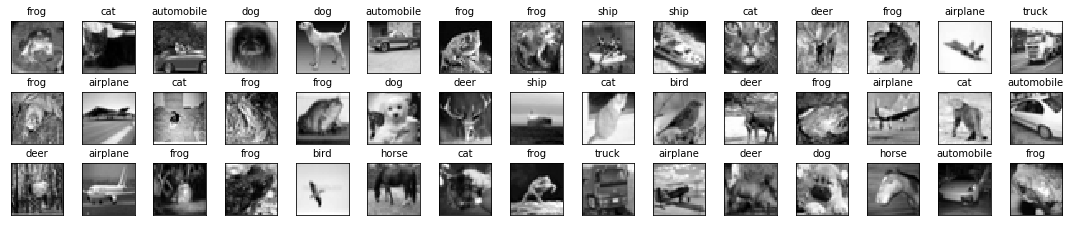

In [5]:
# a helper plotting function
%matplotlib inline

def plot_gallery(images, titles, h, w, n_row=3, n_col=15):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1 * n_col, 1 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(y_label[i], size=10)
        plt.xticks(())
        plt.yticks(())

plot_gallery(X[:45], names, h, w) # defaults to showing a 3 by 6 subset of the faces

As we can see, the images have been converted to grayscale and only 5000 of them have been picked for use. There are no other significant operations that we found appropriate on the processed dataset.

Now, let's see how the instances of our dataset are distributed into the target classes.

Number of instances: 5000
Number of instances in each class: [506 508 510 497 491 483 511 502 504 488]


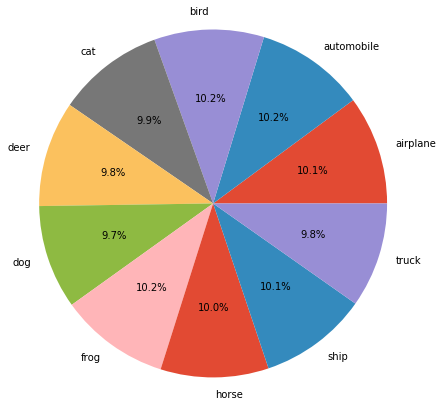

In [6]:
%matplotlib inline
plt.style.use('ggplot')

#=== Fill in code below========
print('Number of instances:', n_samples)
print('Number of instances in each class:', np.bincount(y))
the_grid = GridSpec(1, 1)

plt.subplot(the_grid[0, 0], aspect=1)
plt.pie(np.bincount(y), labels = y_set, autopct='%1.1f%%', radius=2)
plt.show()

Wow! They are so uniformly distributed.

# 3.Evaluation

To evaluate our algorithm’s generalization performance, we have decided to use *Precision Score*. The precision is intuitively the ability of the classifier not to label a negative sample as positive. Based on our business case, the goal is to predict an image correctly. This means that we want to lower the false positives. 



Let us first look at all evaluation metrics, how they score on our dataset. (Just for fun!)

Here we are splitting the data using 80-20 split. Let's see how it goes.

In [4]:
pipe_lr = Pipeline([('scl', StandardScaler()),
                    ('pca', RandomizedPCA(n_components=20,random_state=1)),
                    ('clf', LogisticRegression(class_weight='balanced', random_state=1, penalty='l2'))])

#Split the data into 80-20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1)

pipe_lr.fit(X_train, y_train)
y_pred = pipe_lr.predict(X_test)
print(classification_report(y_test, y_pred, target_names=y_set))

Let us understand this using Confusion Matrix.

In [8]:
cnf_matrix = confusion_matrix(y_test, y_pred)
sum_list = [np.sum(i) for i in cnf_matrix]
mean_list = cnf_matrix.diagonal() / sum_list

print('The precision score is ', np.mean(mean_list), '+-', np.std(mean_list),end=' ')
print('(min,max) (', min(mean_list), max(mean_list),')')

The precision score is  0.297309831341 +- 0.106326289512 (min,max) ( 0.0769230769231 0.409090909091 )


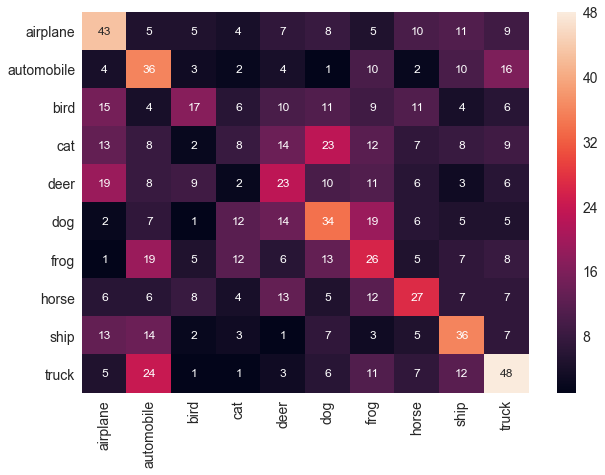

In [9]:
df_cm = pd.DataFrame(cnf_matrix, y_set, y_set)
plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 12})# font size
plt.show()

The values in the above matrix indicate the True-positives (diagonal) and False-positives (non-diagonal). There will not be True-negative and/or False-negative cases with our dataset as this is a  multi-class problem and the prediction will be either same as the actual or it will be some other class. For example, let's say that we predicted an image to be a *cat*. In such case, the actual image can either be *cat* (True-positive) or any other class (False-positive). There is no case as (Actual: Not Cat, Predicted: Not Cat) or (Actual: Not Cat, Predicted: Cat).

Therefore, we think that the most logical approach for evaluating this dataset would be using *Precision Score*, which is defined as (TP / TP + FP).

This problem is a multi-class prediction task, and the class distribution is quite uniform. Hence, we will use *micro-Precision score* to evaluate the performance of our classifier throughout this assignment.
<hr/>

Next, we want to use a cross-validation technique which is appropriate to our dataset to divide it into training and testing sets. As we saw the class distribution earlier, they are all uniformly distributed. Furthermore, we are using a small subset of the dataset i.e. 5000 images out of 50,000.

Considering these facts about the data, we think that using *KFold cross-validation* is going to be the best technique (possibly) to split the data. The purpose of using cross-validation is to create a model which is stable on validation sets which may be uncertain i.e. on each splitting iteration, the results may change. In our case, the validation set created using KFold does not cause unstability because the data is uniformly distributed. Hence, we can say that the KFold generated model mirrors the practical usage of an algorithm.

In [10]:
kfold = KFold(n_splits=5, random_state=1).split(X_train, y_train)
    
scores = []
for k, (train, test) in enumerate(kfold):
    pipe_lr.fit(X_train[train], y_train[train])
    score = pipe_lr.score(X_train[test], y_train[test])
    scores.append(score)
    print('Fold: %s, Acc: %.3f' % (k+1, score))
    
print('\nCV precision: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

Fold: 1, Acc: 0.273
Fold: 2, Acc: 0.271
Fold: 3, Acc: 0.304
Fold: 4, Acc: 0.266
Fold: 5, Acc: 0.251

CV precision: 0.273 +/- 0.017


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class RandomizedPCA is deprecated; RandomizedPCA was deprecated in 0.18 and will be removed in 0.20. Use PCA(svd_solver='randomized') instead. The new implementation DOES NOT store whiten ``components_``. Apply transform to get them.
  warnings.warn(msg, category=DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class RandomizedPCA is deprecated; RandomizedPCA was deprecated in 0.18 and will be removed in 0.20. Use PCA(svd_solver='randomized') instead. The new implementation DOES NOT store whiten ``components_``. Apply transform to get them.
  warnings.warn(msg, category=DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class RandomizedPCA is deprecated; RandomizedPCA was deprecated in 0.18 and will be removed in 0.20. Use PCA(svd_solver='randomized') instead. T

CV precision scores: [ 0.27791563  0.25558313  0.2382134   0.30174564  0.3         0.27        0.2775
  0.25628141  0.26196474  0.22278481]
CV precision: 0.266199 +/- 0.023627


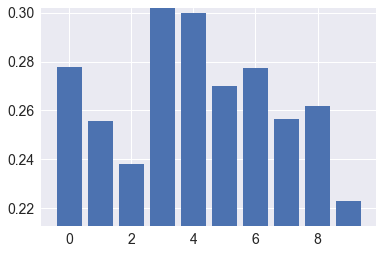

In [11]:
scores = cross_val_score(estimator=pipe_lr,
                         X=X_train,
                         y=y_train,
                         cv=10,
                         n_jobs=-1)
print('CV precision scores: %s' % scores)

plt.bar(range(len(scores)),scores)
plt.ylim([min(scores)-0.01,max(scores)])

print('CV precision: %f +/- %f' % (np.mean(scores), np.std(scores)))

Looking at the scores above, we can baseline a precision of about 27% for our algorithm's performance and try to improve up on it by tuning the hyperparameters.

# 4.Modeling

Now that we know what our evaluation criteria is going to be and how we are splitting the data, let us model a custom multi-layer perceptron. Our implementation fulfills the following requirements:

* When instantiated, a selectable phi function can be used for the initial layer (either sigmoid or linear).
* A selectable cost function can be used when instantiated (either quadratic or cross entropy).
* User can customize the number of hidden layers.

In [12]:
# helper function to plot graphs and print output
%matplotlib inline

plt.style.use('ggplot')

def print_result(nn,X_train,y_train,X_test,y_test,title="",color="red"):
    
    print("=================")
    print(title,":")
    yhat = nn.predict(X_train)
    print('Resubstitution precision:',precision_score(y_train,yhat, average='micro'))
    
    yhat = nn.predict(X_test)
    print('Validation precision:',precision_score(y_test,yhat, average='micro'))
    
    if hasattr(nn,'val_score_'):
        plt.plot(range(len(nn.val_score_)), nn.val_score_, color=color,label=title)
        plt.ylabel('Validation Precision')
    else:
        plt.plot(range(len(nn.score_)), nn.score_, color=color,label=title)
        plt.ylabel('Resub Precision')
        
    plt.xlabel('Epochs')
    plt.tight_layout()
    plt.legend(loc='best')
    plt.grid(True)

In [13]:
#split the data using KFold cross validation
k_fold = KFold(n_splits=5) #gives us an 80-20 split
for train_index, test_index in k_fold.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

In [14]:
# Code adapted from https://github.com/eclarson/MachineLearningNotebooks/blob/master/07.MLPNeuralNetworks.ipynb
# Original Author: Sebastian Raschka
class MultiLayerPerceptron(object):
    def __init__(self, n_hidden=30, C=0.0, epochs=500, eta=0.001, 
                 random_state=None, n_layers=2, cost_function="mse", activation_function='sigmoid'):
        np.random.seed(random_state)
        self.n_hidden = n_hidden
        self.l2_C = C
        self.epochs = epochs
        self.eta = eta
        self.n_layers = n_layers
        self.cost_function = cost_function
        self.activation_function = activation_function
        
        
    @staticmethod
    def _encode_labels(y):
        """Encode labels into one-hot representation"""
        onehot = pd.get_dummies(y).values.T   
        return onehot

    def _initialize_weights(self):
        """Initialize weights with small random numbers."""
        W = []
        
        W_num_elems = (self.n_features_ + 1)*self.n_hidden
        W.append(np.random.uniform(-1.0, 1.0, size=W_num_elems))
        W[0] = W[0].reshape(self.n_hidden, self.n_features_ + 1)
        
        for i in range(1,self.n_layers):
            if i == self.n_layers-1:
                W_num_elems = (self.n_hidden + 1)*self.n_output_
                W.append(np.random.uniform(-1.0, 1.0, size=W_num_elems))
                W[i] = W[i].reshape(self.n_output_, self.n_hidden + 1)
            else:
                W_num_elems = (self.n_hidden + 1)*self.n_hidden 
                W.append(np.random.uniform(-1.0, 1.0, size=W_num_elems))
                W[i] = W[i].reshape(self.n_hidden, self.n_hidden + 1)
            
        return W
    
    @staticmethod
    def _linear(z):
        return z
    
    @staticmethod
    def _sigmoid(z):
        """Use scipy.special.expit to avoid overflow"""
        # 1.0 / (1.0 + np.exp(-z))
        return expit(z)
    
    @staticmethod
    def _add_bias_unit(X, how='column'):
        """Add bias unit (column or row of 1s) to array at index 0"""
        if how == 'column':
            ones = np.ones((X.shape[0], 1))
            X_new = np.hstack((ones, X))
        elif how == 'row':
            ones = np.ones((1, X.shape[1]))
            X_new = np.vstack((ones, X))
        return X_new
    
    @staticmethod
    def _L2_reg(lambda_, W):
        """Compute L2-regularization cost"""
        # only compute for non-bias terms
        w_mean = 0
        for w in W:
            w_mean += np.mean(w[:, 1:] ** 2)
        
        return (lambda_/2.0) * w_mean
    
    def _cost(self,A_n,Y_enc,W):
        '''Get the objective function value'''
        if self.cost_function == 'mse':
            cost = np.mean((Y_enc-A_n)**2)
        elif self.cost_function == 'crossentropy':
            cost = -np.mean(np.nan_to_num((Y_enc*np.log(A_n)+(1-Y_enc)*np.log(1-A_n))))
        L2_term = self._L2_reg(self.l2_C, W)
        return cost + L2_term
    
    def _feedforward(self, X, W):
        A = []
        Z = []
        A.append(self._add_bias_unit(X, how='column'))
        A[0] = A[0].T
        Z.append(W[0] @ A[0])
        
        for i in range(1,self.n_layers):
            if self.activation_function == 'sigmoid':
                A.append(self._sigmoid(Z[i-1]))
            elif self.activation_function == 'linear':
                A.append(self._linear(Z[i-1]))
            A[i] = self._add_bias_unit(A[i], how='row')
            Z.append(W[i] @ A[i])
            
        if self.activation_function == 'sigmoid':
            A_n = self._sigmoid(Z[len(Z)-1])
        elif self.activation_function == 'linear':
            A_n = self._linear(Z[len(Z)-1])
            
        return A, Z, A_n
    
    def _get_gradient(self, A, A_n, Z, Y_enc, W):
        """ Compute gradient step using backpropagation.
        """
        grad = []
        V = []
        for i in range(self.n_layers):
            grad.append(np.zeros(W[i].shape))
            V.append(np.zeros(W[i].shape))
            
        # vectorized backpropagation
        if self.cost_function == 'mse':
            V[self.n_layers-1] = -2*(Y_enc-A_n)*A_n*(1-A_n)
        elif self.cost_function == 'crossentropy':
            V[self.n_layers-1] = (A_n-Y_enc)
        
        grad[self.n_layers-1] = V[self.n_layers-1] @ A[self.n_layers-1].T
        
        for i in reversed(range(self.n_layers-1)):
            if self.activation_function == 'sigmoid':
                V[i] = A[i+1]*(1-A[i+1])*(W[i+1].T @ V[i+1])
            elif self.activation_function == 'linear':
                V[i] = (W[i+1].T @ V[i+1])
            grad[i] = V[i][1:,:] @ A[i].T
            V[i] = V[i][1:,:] 
        
        # regularize weights that are not bias terms
        for i in range(len(grad)):
            grad[i][:, 1:] += (W[i][:, 1:] * self.l2_C)
        
        return grad
    
    def predict(self, X):
        """Predict class labels"""
        _, _, A_n = self._feedforward(X, self.W)
        y_pred = np.argmax(A_n, axis=0)
        return y_pred
    
    def fit(self, X, y, print_progress=False, XY_test=None):
        """ Learn weights from training data."""
        
        X_data, y_data = X.copy(), y.copy()
        Y_enc = self._encode_labels(y)
        
        # init weights and setup matrices
        self.n_features_ = X_data.shape[1]
        self.n_output_ = Y_enc.shape[0]
        self.W = self._initialize_weights()

        self.cost_ = []
        self.score_ = []
        self.grad_w_ = []
        if XY_test is not None:
            X_test = XY_test[0].copy()
            y_test = XY_test[1].copy()
            self.val_score_ = []
            
        for i in range(self.n_layers):
            self.grad_w_.append([])
            
        for i in range(self.epochs):

            if print_progress>0 and (i+1)%print_progress==0:
                sys.stderr.write('\rEpoch: %d/%d' % (i+1, self.epochs))
                sys.stderr.flush()

            # feedforward all instances
            A, Z, A_n = self._feedforward(X_data,self.W)
            
            cost = self._cost(A_n,Y_enc,self.W)
            self.cost_.append(cost)
            self.score_.append(precision_score(y_data, self.predict(X_data), average='micro'))
            if XY_test is not None:
                self.val_score_.append(precision_score(y_test, self.predict(X_test), average='micro'))

            # compute gradient via backpropagation
            grad = self._get_gradient(A=A, A_n=A_n, Z=Z, Y_enc=Y_enc, W=self.W)
            
            for i in range(self.n_layers):
                self.grad_w_[i].append(np.mean(np.abs(grad[i])))
        
            for i in range(len(self.W)):
                self.W[i] -= self.eta * grad[i]
                
        for i in range(self.n_layers):
            self.grad_w_[i] = np.array(self.grad_w_[i])

        return self

In [15]:
# Define parameter for MLP
params = dict(n_hidden=50, 
              C=0.01, # tradeoff L2 regularizer
              epochs=100, # iterations
              eta=0.001,  # learning rate
              random_state=1,
              n_layers=3,
              cost_function = 'mse',
              activation_function = 'linear')

Using our custom MLP, we will now look at the results using different hyperparameters.

### 4.1 Linear Activation Function

In [16]:
params['activation_function'] = "linear"
params['cost_function'] = "mse"
nn_lin_mse = MultiLayerPerceptron(**params)
%time nn_lin_mse.fit(X_train, y_train, print_progress=10)
yhat = nn_lin_mse.predict(X_test)
print('Precision:', precision_score(y_test,yhat, average='micro'))

params['cost_function'] = "crossentropy"
nn_lin_ce = MultiLayerPerceptron(**params)
%time nn_lin_ce.fit(X_train, y_train, print_progress=10)
yhat = nn_lin_ce.predict(X_test)
print('Precision:', precision_score(y_test,yhat, average='micro'))

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:76: RuntimeWarning: overflow encountered in square
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:115: RuntimeWarning: overflow encountered in multiply
Epoch: 100/100

Wall time: 17.5 s
Precision: 0.094


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: RuntimeWarning: invalid value encountered in log
Epoch: 100/100

Wall time: 15.9 s
Precision: 0.094


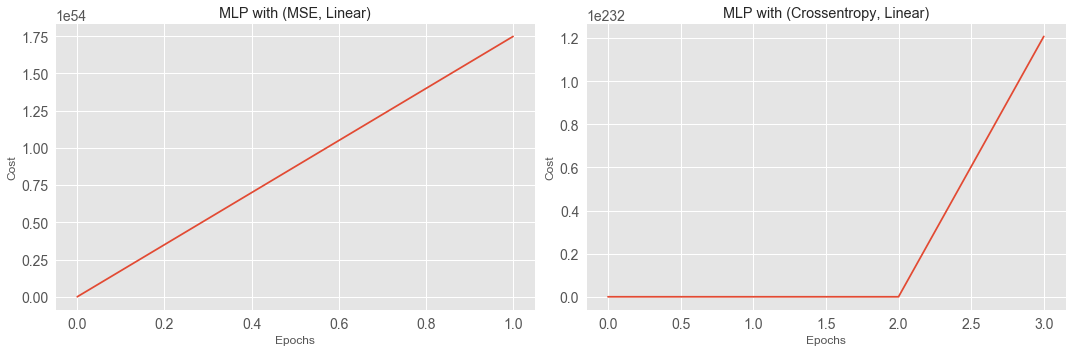

In [17]:
# Visualize the cost for different cost function
plt.figure(figsize=(15, 5))
plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)

plt.subplot(1, 2, 1)
plt.plot(range(len(nn_lin_mse.cost_)), nn_lin_mse.cost_)
plt.ylabel('Cost')
plt.xlabel('Epochs')
plt.title('MLP with (MSE, Linear)')
plt.tight_layout()

plt.subplot(1, 2, 2)
plt.plot(range(len(nn_lin_ce.cost_)), nn_lin_ce.cost_)
plt.ylabel('Cost')
plt.xlabel('Epochs')
plt.title('MLP with (Crossentropy, Linear)')
plt.tight_layout()

plt.show()

### 4.2 Sigmoid Activation Function

In [18]:
params['activation_function'] = "sigmoid"
params['cost_function'] = "mse"
nn_sig_mse = MultiLayerPerceptron(**params)
%time nn_sig_mse.fit(X_train, y_train, print_progress=10)
yhat = nn_sig_mse.predict(X_test)
print('Precision:', precision_score(y_test,yhat, average='micro'))

params['cost_function'] = "crossentropy"
nn_sig_ce = MultiLayerPerceptron(**params)
%time nn_sig_ce.fit(X_train, y_train, print_progress=10)
yhat = nn_sig_ce.predict(X_test)
print('Precision:', precision_score(y_test,yhat, average='micro'))

Epoch: 100/100

Wall time: 21.8 s
Precision: 0.112


Epoch: 100/100

Wall time: 19.9 s
Precision: 0.225


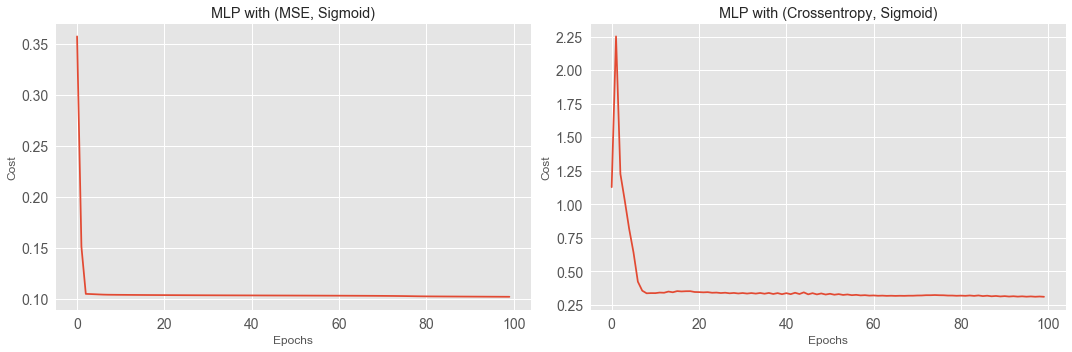

In [19]:
# Visualize the cost for different cost function
plt.figure(figsize=(15, 5))
plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)

plt.subplot(1, 2, 1)
plt.plot(range(len(nn_sig_mse.cost_)), nn_sig_mse.cost_)
plt.ylabel('Cost')
plt.xlabel('Epochs')
plt.title('MLP with (MSE, Sigmoid)')
plt.tight_layout()

plt.subplot(1, 2, 2)
plt.plot(range(len(nn_sig_ce.cost_)), nn_sig_ce.cost_)
plt.ylabel('Cost')
plt.xlabel('Epochs')
plt.title('MLP with (Crossentropy, Sigmoid)')
plt.tight_layout()

plt.show()

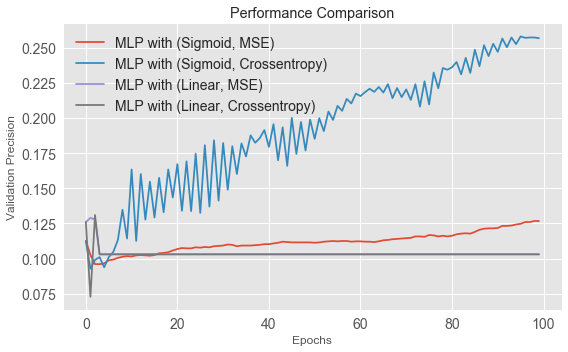

In [32]:
plt.style.use('ggplot')
plt.figure(figsize=(8, 5))

plt.plot(range(len(nn_sig_mse.score_)), nn_sig_mse.score_, label='MLP with (Sigmoid, MSE)')
plt.plot(range(len(nn_sig_ce.score_)), nn_sig_ce.score_, label='MLP with (Sigmoid, Crossentropy)')
plt.plot(range(len(nn_lin_mse.score_)), nn_lin_mse.score_, label='MLP with (Linear, MSE)')
plt.plot(range(len(nn_lin_ce.score_)), nn_lin_ce.score_, label='MLP with (Linear, Crossentropy)')

plt.legend()
plt.ylabel('Validation Precision')
plt.xlabel('Epochs')
plt.title('Performance Comparison')
plt.tight_layout()
plt.show()

It is quite clear that the model with Sigmoid activation function and Cross-entropy cost function is a better performer so far. We will choose this model to visualize the magnitude of gradient at each layer.

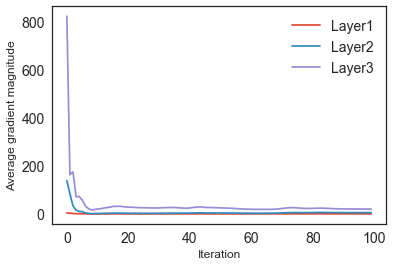

In [21]:
# Visualize the gradient magnitude at each layer
plt.style.use('seaborn-white')
ax = plt.subplot(1,1,1)
for i in range(len(nn_sig_ce.grad_w_)):
    plt.plot(np.abs(nn_sig_ce.grad_w_[i]), label='Layer'+str(i+1))
plt.legend()
plt.ylabel('Average gradient magnitude')
plt.xlabel('Iteration')
plt.grid(False)

plt.show()

From the above graph (implemented for 3 hidden layers), we can see that the gradients appear to converge. Also, the gradient magnitudes are not consistent across the layers and the learning rate increases as we go up the layers.

# 5.Exceptional Work

### 5.1 Additional Analysis

Now we would like to see if our perceptron can deliver similar performance when run with pipeline.

In [22]:
pipe_lr = Pipeline([('scl', StandardScaler()),
                    ('pca', RandomizedPCA(n_components=300,random_state=1)),
                    ('clf', MultiLayerPerceptron(**params))])

pipe_lr.fit(X_train, y_train)
y_pred = pipe_lr.predict(X_test)
print(classification_report(y_test, y_pred, target_names=y_set))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class RandomizedPCA is deprecated; RandomizedPCA was deprecated in 0.18 and will be removed in 0.20. Use PCA(svd_solver='randomized') instead. The new implementation DOES NOT store whiten ``components_``. Apply transform to get them.
  warnings.warn(msg, category=DeprecationWarning)


             precision    recall  f1-score   support

   airplane       0.00      0.00      0.00        94
 automobile       0.20      0.44      0.27       108
       bird       0.20      0.05      0.08       116
        cat       0.11      0.04      0.06        95
       deer       0.26      0.10      0.14       120
        dog       0.16      0.35      0.22        81
       frog       0.18      0.23      0.20        94
      horse       0.19      0.32      0.24        92
       ship       0.57      0.08      0.14       100
      truck       0.24      0.44      0.31       100

avg / total       0.21      0.20      0.17      1000



Our model was around 22% while the above results show 21% precision.

### 5.2 ReLu & SiLu

**ReLu:** Stands for *Rectified Linear Unit*. It can be efficiently computed without making a significant difference to generalization accuracy, as compared to other conventional activation functions like the sigmoid. ReLu adds non linearity to the network.

We define the ReLu neuron as:

$$
    \phi(\mathbf{z}^{(i)})=\left\{
                \begin{array}{ll}
                \mathbf{z}^{(i)}  \text{,  if }\mathbf{z}^{(i)}>0 \\
                \mathbf{0} \text{,      else } \\
                \end{array}
              \right.
$$

Which has a very simple derivative:
$$
    \frac{\partial\phi(\mathbf{z}^{(i)})}{\partial\mathbf{z}^{(i)}}=\left\{
                \begin{array}{ll}
                \mathbf{1} \text{,  if }\mathbf{z}^{(i)}>0 \\
                \mathbf{0} \text{,      else } \\
                \end{array}
              \right.
$$

**SiLu:** Stands for *Sigmoid-Weighted Linear Unit*. The only difference from ReLu is that we multiply Z with sigmoid value of Z to get the activation function.


A SiLu neuron is defined as:
$$
    \phi(\mathbf{z}) = \mathbf{z}\cdot\sigma(\mathbf{z})
$$

And it's derivative is:
$$
    \frac{\partial\phi(\mathbf{z})}{\partial\mathbf{z}} = \phi(\mathbf{z})+\sigma(\mathbf{z}[1-\phi(\mathbf{z})]
$$

$$
    \frac{\partial\phi(\mathbf{z})}{\partial\mathbf{z}} = \mathbf{a}^{(l+1)}+\sigma(\mathbf{z}^{(l)}\cdot[1-\mathbf{a}^{(l+1)}]
$$

Let us implement them both and compare their performances with our previous models.

In [23]:
class MLPWithActivationFunction(MultiLayerPerceptron):
    def __init__(self, dropout=0.2, minibatches=50, alpha=0.0, decrease_const=0.0, 
                 shuffle=True, **params):
        self.dropout = dropout
        self.minibatches = minibatches
        self.decrease_const = decrease_const
        self.alpha = alpha
        self.shuffle = shuffle
        super().__init__(**params)
        
    def _initialize_weights(self):
        """Initialize weights with small random numbers."""
        # suggested relu/sigmoid bounds
        #Xavier Glorot, Yoshua Bengio ; 
        #  Understanding the difficulty of training deep feedforward neural networks
        #  Conference on Artificial Intelligence and Statistics, PMLR 9:249-256, 2010.
        W = []
        
        init_bound = np.sqrt(6. / (self.n_hidden + self.n_features_ + 1))
        W.append(np.random.uniform(-init_bound, init_bound,(self.n_hidden, self.n_features_ + 1)))
        W[0][:,:1] = 0
        
        # reduce the final layer magnitude in order to balance the size of the gradients
        # between 
        
        for i in range(1,self.n_layers):
            if i == self.n_layers-1:
                init_bound = np.sqrt(0.5 / (self.n_output_ + self.n_hidden + 1))
                W.append(np.random.uniform(-init_bound, init_bound,(self.n_output_, self.n_hidden + 1)) )
                W[i][:,:1] = 0
            else:
                init_bound = np.sqrt(0.5 / (self.n_hidden + self.n_hidden + 1))
                W.append(np.random.uniform(-init_bound, init_bound,(self.n_hidden, self.n_hidden + 1)) )
                W[i][:,:1] = 0
        
        return W
    
    @staticmethod
    def _relu(Z):
        return np.maximum(0,Z.copy())
    
    def _silu(self, Z):
        return Z * self._sigmoid(Z)
        
    def _feedforward(self, X, W):
        """Compute feedforward step
        """
        A = []
        Z = []
        
        # A1->W1->ReLu->A2->W2->Sigmoid
        A.append(self._add_bias_unit(X, how='column'))
        A[0] = A[0].T
        Z.append(W[0] @ A[0])
        
        for i in range(1,self.n_layers):
            if self.activation_function == 'relu':
                A.append(self._relu(Z[i-1]))
            elif self.activation_function == 'silu':
                A.append(self._silu(Z[i-1]))
                
            A[i] = self._add_bias_unit(A[i], how='row')
            Z.append(W[i] @ A[i])
            
        A_n = self._sigmoid(Z[len(Z)-1])   # never use relu as last layer for classification (yuck!)
        return A, Z, A_n
    
    def _get_gradient(self, A, A_n, Z, Y_enc, W):
        """ Compute gradient step using backpropagation.
        """
        grad = []
        V = []
        for i in range(self.n_layers):
            grad.append(np.zeros(W[i].shape))
            V.append(np.zeros(W[i].shape))
            
        # vectorized backpropagation
        V[self.n_layers-1] = A_n-Y_enc
        grad[self.n_layers-1] = V[self.n_layers-1] @ A[self.n_layers-1].T
        
        for i in reversed(range(self.n_layers-1)):            
            V[i] = (W[i+1].T @ V[i+1])
            Z_with_bias = self._add_bias_unit(Z[i],how='row')
            
            if self.activation_function == 'relu':
                V[i][Z_with_bias<=0] = 0
            elif self.activation_function == 'silu':
                V[i] *= A[i+1] + (self._sigmoid(Z_with_bias[i]) * (1 - A[i+1]))
                
            grad[i] = V[i][1:,:] @ A[i].T
            V[i] = V[i][1:,:]
        
        # regularize weights that are not bias terms
        for i in range(len(grad)):
            grad[i][:, 1:] += (W[i][:, 1:] * self.l2_C)

        return grad
    

    def fit(self, X, y, print_progress=0, XY_test=None):
        """ Learn weights from training data. With mini-batch"""
        X_data, y_data = X.copy(), y.copy()
        Y_enc = self._encode_labels(y)
        delta_W_prev = []
        
        # init weights and setup matrices
        self.n_features_ = X_data.shape[1]
        self.n_output_ = Y_enc.shape[0]
        self.W = self._initialize_weights()

        for i in range(self.n_layers):
            delta_W_prev.append(np.zeros(self.W[i].shape))

        self.cost_ = []
        cost = []
        self.score_ = []
        self.grad_w_ = []
        
        if XY_test is not None:
            X_test = XY_test[0].copy()
            y_test = XY_test[1].copy()
            self.val_score_ = []

        for i in range(self.n_layers):
            self.grad_w_.append([])

        for i in range(self.epochs):
            # adaptive learning rate
            self.eta /= (1 + self.decrease_const*i)

            if print_progress>0 and (i+1)%print_progress==0:
                sys.stderr.write('\rEpoch: %d/%d' % (i+1, self.epochs))
                sys.stderr.flush()

            if self.shuffle:
                idx_shuffle = np.random.permutation(y_data.shape[0])
                X_data, Y_enc, y_data = X_data[idx_shuffle], Y_enc[:, idx_shuffle], y_data[idx_shuffle]

            mini = np.array_split(range(y_data.shape[0]), self.minibatches)
            mini_cost = []
            
            # adding dropout neurons
            W = self.W.copy()
            
            delta_W_prev_dropout = []
            
            if self.dropout>0.0:
                
                idx_dropout = np.random.permutation(W[0].shape[0])
                idx_dropout = idx_dropout[int(W[0].shape[0]*self.dropout):]
                idx_dropout = np.sort(idx_dropout)

                idx_W_withbias = np.hstack(([0],(idx_dropout+1)))

                W[0] = W[0][idx_dropout,:]# get rid of rows
                for i in range(1, self.n_layers):
                    W[i] = W[i][:,idx_W_withbias]# get rid of extra columns

                delta_W_prev_dropout.append(delta_W_prev[0][idx_dropout,:])
                for i in range(1, self.n_layers): 
                    delta_W_prev_dropout.append(delta_W_prev[i][:,idx_W_withbias])
            else:
                delta_W_prev_dropout = delta_W_prev
            
            mini_grad_w = []
            for i in range(self.n_layers):
                mini_grad_w.append([])
            
            for idx in mini:
                # feedforward
                A, Z, A_n = self._feedforward(X_data[idx], self.W)
                
                cost = self._cost(A_n,Y_enc[:, idx],self.W)
                mini_cost.append(cost) # this appends cost of mini-batch only

                # compute gradient via backpropagation
                grad = self._get_gradient(A,A_n=A_n,Z=Z,Y_enc=Y_enc[:,idx],W=self.W)

                for g in enumerate(grad):
                    mini_grad_w[g[0]].append(g[1])
                    
                delta_W = []
                for i in range(self.n_layers):
                    delta_W.append(self.eta * grad[i])
                    self.W[i] -= (delta_W[i] + (self.alpha * delta_W_prev[i]))
                    delta_W_prev[i] = delta_W[i]
                    
            if self.dropout>0.0:
                # now append the learned weights back into the original matrices
                self.W[0][idx_dropout,:] = W[0]
                delta_W_prev[0][idx_dropout,:] = delta_W_prev_dropout[0]
                
                for i in range(1, self.n_layers):
                    self.W[i][:,idx_W_withbias] = W[i]
                    delta_W_prev[i][:,idx_W_withbias] = delta_W_prev_dropout[i]
                    
            else:
                # don't eliminate any neurons
                self.W = W
                delta_W_prev = delta_W_prev_dropout
            
            for k in range(self.n_layers):
                self.grad_w_[k].append(np.median(np.abs(mini_grad_w[k])))
                
            self.score_.append(precision_score(y_data, self.predict(X_data), average='micro'))
            self.cost_.append(mini_cost) # only uses dropped samples, so more noise
            if XY_test is not None:
                self.val_score_.append(precision_score(y_test, self.predict(X_test), average='micro'))
        
        for i in range(self.n_layers):
            self.grad_w_[i] = np.array(self.grad_w_[i])
        
        return self

In [24]:
# Define the parameters
params = dict(n_hidden=50, 
              C=0.01, # tradeoff L2 regularizer
              epochs=100, # iterations
              eta=0.001,  # learning rate
              random_state=1,
              n_layers=3, 
              minibatches=512,
              dropout=0.25,
              alpha=1e-4, 
              decrease_const=1e-9, 
              cost_function = 'mse',
              activation_function = 'relu')

In [25]:
params['activation_function'] = 'relu'
nn_relu = MLPWithActivationFunction(**params) # same as previous parameter values
%time nn_relu.fit(X_train, y_train, print_progress=True)
yhat = nn_relu.predict(X_test)
print('Precision score:', precision_score(y_test,yhat, average='micro'))

Epoch: 100/100

Wall time: 3min 37s
Precision score: 0.313


In [26]:
params['activation_function'] = 'silu'

nn_silu = MLPWithActivationFunction(**params) # same as previous parameter values
%time nn_silu.fit(X_train, y_train, print_progress=True)
yhat = nn_silu.predict(X_test)
print('Precision score:', precision_score(y_test,yhat, average='micro'))

Epoch: 100/100

Wall time: 3min 36s
Precision score: 0.295


Comparing their performances with Linear and Sigmoid.

MLP with (Crossentropy, Linear) :
Resubstitution precision: 0.103
Validation precision: 0.094
MLP with (Crossentropy, Sigmoid) :
Resubstitution precision: 0.25975
Validation precision: 0.225
ReLU Perceptron :
Resubstitution precision: 0.41075
Validation precision: 0.313
SiLU Perceptron :
Resubstitution precision: 0.326
Validation precision: 0.295


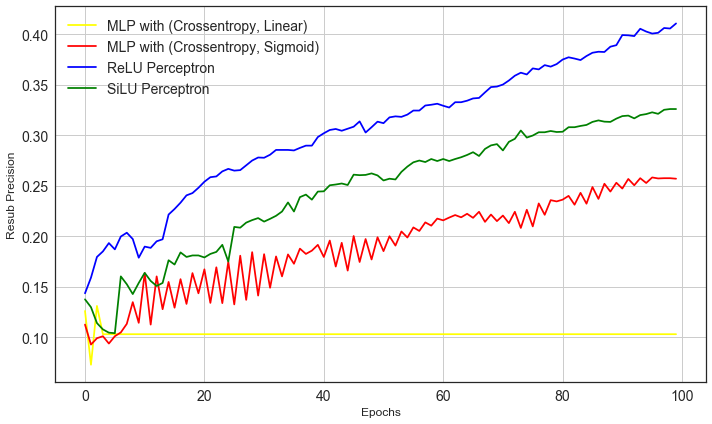

In [27]:
plt.figure(figsize=(10, 6))

print_result(nn_lin_ce,X_train,y_train,X_test,y_test,title="MLP with (Crossentropy, Linear)",color="yellow")
print_result(nn_sig_ce,X_train,y_train,X_test,y_test,title="MLP with (Crossentropy, Sigmoid)",color="red")
print_result(nn_relu,X_train,y_train,X_test,y_test,title="ReLU Perceptron",color="blue")
print_result(nn_silu,X_train,y_train,X_test,y_test,title="SiLU Perceptron",color="green")

plt.show()

ReLu wins!! It is clear from the above graph that ReLu has the best performance on our dataset followed by SiLu, Sigmoid, and Linear activation functions.

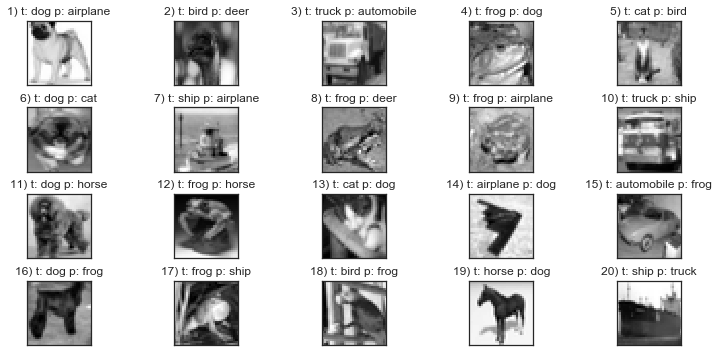

In [28]:
yhat = nn_relu.predict(X_test)

miscl_img = X_test[y_test != yhat][:20]
correct_lab = y_test[y_test != yhat][:20]
miscl_lab = yhat[y_test != yhat][:20]

plt.figure(figsize=(10, 5))
plt.subplots_adjust(bottom=0, left=.01, right=1, top=.90, hspace=.35)
for i in range(4 * 5):
    plt.subplot(4, 5, i + 1)
    img = miscl_img[i].reshape(h, w)
    plt.imshow(img, cmap=plt.cm.gray)
    plt.title('%d) t: %s p: %s' % (i+1, y_set[correct_lab[i]], y_set[miscl_lab[i]]), size=12)
    plt.xticks(())
    plt.yticks(())

Now, let us visualize the evaluation metric versus the hyper-parameters for all the models that we have implemented so far.

In [29]:
cost_fun = ['mse', 'crossentropy']
activation_fun = ['linear', 'sigmoid', 'relu', 'silu']
no_of_layers = [2, 3, 7]
d = {'Precision_score': [], 'Cost_score': [], 'Model': []}

params1 = dict(n_hidden=50, 
              C=0.01, # tradeoff L2 regularizer
              epochs=100, # iterations
              eta=0.001,  # learning rate
              random_state=1
             )
params2 = dict(minibatches=512,
              alpha=1e-4, 
              decrease_const=1e-9,
              dropout=0.25)

for (a, c, n) in itertools.product(activation_fun, cost_fun, no_of_layers):
    params1['activation_function'] = a
    params1['cost_function'] = c
    params1['n_layers'] = n
    
    if a == 'linear' or a == 'sigmoid':
        nn = MultiLayerPerceptron(**params1)
    else:
        nn = MLPWithActivationFunction(**params1, **params2)
        
    nn.fit(X = X_train, y = y_train)
    
    d['Precision_score'] += nn.score_
    d['Cost_score'] += nn.cost_
    d['Model'] += [a.capitalize() + ", " + c.capitalize() + ", " + str(n) + " Layers"]*len(nn.score_)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:115: RuntimeWarning: overflow encountered in multiply
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:76: RuntimeWarning: overflow encountered in square
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: RuntimeWarning: invalid value encountered in log


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23]), <a list of 24 Text xticklabel objects>)

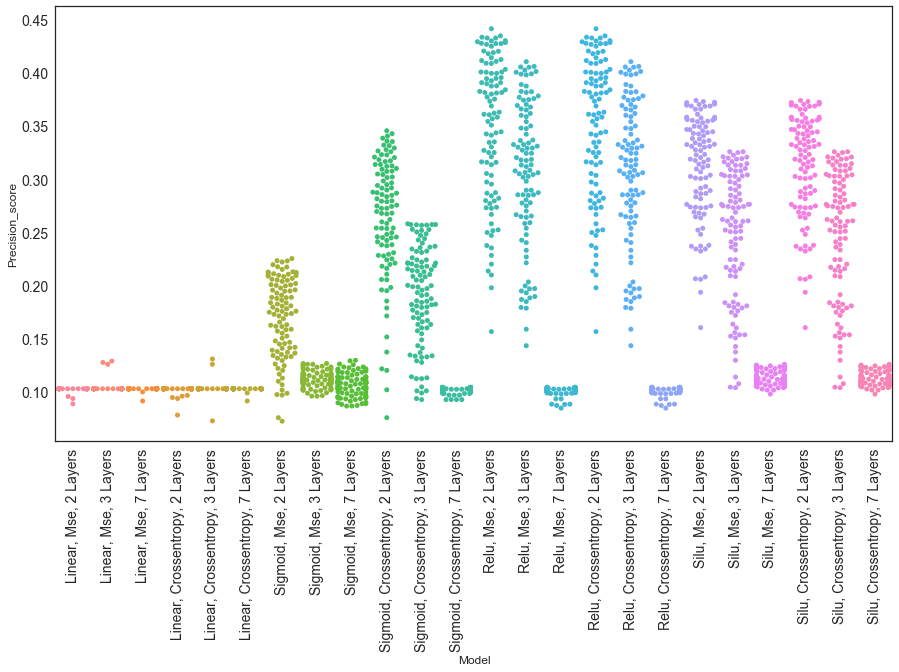

In [30]:
plt.figure(figsize=(15,8))
df = pd.DataFrame(data=d)
ax = sns.swarmplot(x="Model", y="Precision_score", data=df)
plt.xticks(rotation=90)

The above graphs shows that ReLu has the best performance with 2 layers, irrespective of the cost function. The same independence from cost function can be observed for SiLu.

Now that we have our best performer, let's compare it with the Scikit-learn implemented model.

In [31]:
clf = MLPClassifier(hidden_layer_sizes=(50, ), 
                    activation='relu', # type of non-linearity, every layer
                    solver='sgd', 
                    alpha=1e-4, # L2 penalty
                    batch_size= 'auto', # min of 200, num_samples
                    learning_rate='constant', # adapt learning? only for sgd
                    learning_rate_init=0.1, # only SGD
                    power_t=0.0,    # only SGD with inverse scaling of learning rate
                    max_iter=100, # stopping criteria
                    shuffle=True, 
                    random_state=1, 
                    tol=0, # for stopping
                    verbose=False, 
                    warm_start=False, 
                    momentum=0.9, # only SGD
                    nesterovs_momentum=False, # only SGD
                    early_stopping=False, 
                    validation_fraction=0.0, # only if early_stop is true
                    beta_1=0.9, # adam decay rate of moment
                    beta_2=0.999, # adam decay rate of moment
                    epsilon=1e-08) # adam numerical stabilizer

%time clf.fit(X_train,y_train)
yhat = clf.predict(X_test)
print('Validation Acc:',precision_score(yhat,y_test, average='micro'))

Wall time: 9.07 s
Validation Acc: 0.271


# References:

* https://www.marutitech.com/working-image-recognition/

* https://www.quora.com/What-are-some-interesting-applications-of-object-detection

* https://www.programmableweb.com/news/how-businesses-use-image-recognition-to-understand-digital-data/sponsored-content/2014/05/21

* https://economictimes.indiatimes.com/tech/software/how-image-processing-will-change-your-world-in-future/articleshow/10394958.cms

* https://www.cs.toronto.edu/~kriz/cifar.html

* https://www.kaggle.com/c/cifar-10/data

* https://stats.stackexchange.com/questions/301462/what-is-the-purpose-of-crossvalidation